In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
from sklearn.model_selection import train_test_split 

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Kaggle Datasets/Skin Cancer MNIST/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:
df_1 = df[(df['localization'] != "unknown") & (df['sex'] != "unknown")]
df_1.dropna(inplace=True,axis=0)
null_columns=df_1.columns[df.isnull().any()]
null_columns

# Number of missings in each column
df_1[null_columns].isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


age    0
dtype: int64

In [ ]:
%load_ext google.colab.data_table
pd.crosstab(index=df_1['dx'],columns=df_1['localization'],
            margins=True,normalize='all')*100

localization,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,upper extremity,All
dx,,,,,,,,,,,,,,,
akiec,0.051224,0.000000,0.297101,0.122938,0.030735,1.157668,0.000000,0.000000,0.133183,0.665915,0.102449,0.143428,0.010245,0.635181,3.350067
bcc,0.184407,0.000000,1.905542,0.481508,0.000000,1.034730,0.040979,0.000000,0.020490,0.594201,0.143428,0.194652,0.112693,0.501998,5.214630
bkl,0.430284,0.000000,2.069460,0.758119,0.061469,3.268108,0.010245,0.020490,0.143428,1.782604,0.317590,0.348325,0.747874,1.065465,11.023461
df,0.040979,0.000000,0.020490,0.000000,0.000000,0.000000,0.020490,0.010245,0.000000,0.840078,0.000000,0.000000,0.000000,0.245876,1.178158
mel,0.676160,0.000000,3.319332,0.696650,0.174162,1.044975,0.286856,0.000000,0.010245,1.967012,0.297101,0.143428,0.481508,2.182153,11.279582
nv,8.779838,0.071714,14.598914,2.028481,0.307346,1.024485,2.858314,0.461018,0.563467,15.152136,0.829833,0.461018,12.672882,6.689888,66.499334
vasc,0.276611,0.000000,0.225387,0.061469,0.000000,0.081959,0.000000,0.000000,0.051224,0.276611,0.030735,0.020490,0.317590,0.112693,1.454769
All,10.439504,0.071714,22.436226,4.149165,0.573712,7.611925,3.216884,0.491753,0.922037,21.278558,1.721135,1.311341,14.342793,11.433255,100.000000


In [ ]:
y = df_1['dx']
y.value_counts()

nv       6491
mel      1101
bkl      1076
bcc       509
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [ ]:

y.shape

(9761,)

In [ ]:
df_1['image_id'] = df_1['image_id']+'.jpg'
X = df_1[['image_id','dx','age','sex','dx_type','localization']]
X_aux = pd.get_dummies(X.iloc[:,2:],drop_first=True)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaledX = scaler.fit_transform(X_aux)
X_aux = pd.DataFrame(scaledX,columns=X_aux.columns,index=df_1['image_id'])
X_aux.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,age,sex_male,dx_type_consensus,dx_type_follow_up,dx_type_histo,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_upper extremity
image_id,,,,,,,,,,,,,,,,,,
ISIC_0027419.jpg,0.941176,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ISIC_0025030.jpg,0.941176,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ISIC_0026769.jpg,0.941176,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ISIC_0025661.jpg,0.941176,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ISIC_0031633.jpg,0.882353,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(X_aux.shape)
print(X.shape)

(9761, 18)
(9761, 6)


In [ ]:
X.head()

,image_id,dx,age,sex,dx_type,localization
0,ISIC_0027419.jpg,bkl,80.0,male,histo,scalp
1,ISIC_0025030.jpg,bkl,80.0,male,histo,scalp
2,ISIC_0026769.jpg,bkl,80.0,male,histo,scalp
3,ISIC_0025661.jpg,bkl,80.0,male,histo,scalp
4,ISIC_0031633.jpg,bkl,75.0,male,histo,ear


In [ ]:
X_required = X[['image_id','dx']]
X_required.index = X_required['image_id'].values
X_required.head()

,image_id,dx
ISIC_0027419.jpg,ISIC_0027419.jpg,bkl
ISIC_0025030.jpg,ISIC_0025030.jpg,bkl
ISIC_0026769.jpg,ISIC_0026769.jpg,bkl
ISIC_0025661.jpg,ISIC_0025661.jpg,bkl
ISIC_0031633.jpg,ISIC_0031633.jpg,bkl


In [ ]:
X_required.shape

(9761, 2)

In [ ]:
X2 = pd.concat([X_required,X_aux],axis=1,ignore_index=False)
X2.shape

(9761, 20)

In [ ]:
X2

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 190, in _repr_javascript_module_
    return self._gen_js(self._preprocess_dataframe())
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 166, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 4859, in reset_index
    new_obj.insert(0, name, level_values)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 3628, in insert
    self._mgr.insert(loc, column, value, allow_duplicates=allow_duplicates)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/internals/managers.py", line 1186, in insert
    raise ValueError(f"cannot insert {item}, already exists")
ValueError: cannot insert image_id, already exists


,image_id,dx,age,sex_male,dx_type_consensus,dx_type_follow_up,dx_type_histo,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_upper extremity
image_id,,,,,,,,,,,,,,,,,,,,
ISIC_0027419.jpg,ISIC_0027419.jpg,bkl,0.941176,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ISIC_0025030.jpg,ISIC_0025030.jpg,bkl,0.941176,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ISIC_0026769.jpg,ISIC_0026769.jpg,bkl,0.941176,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ISIC_0025661.jpg,ISIC_0025661.jpg,bkl,0.941176,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ISIC_0031633.jpg,ISIC_0031633.jpg,bkl,0.882353,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ISIC_0033084.jpg,ISIC_0033084.jpg,akiec,0.470588,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0033550.jpg,ISIC_0033550.jpg,akiec,0.470588,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0033536.jpg,ISIC_0033536.jpg,akiec,0.470588,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(y.shape)
print(X2.shape)
print(df_1.shape)

(9761,)
(9761, 20)
(9761, 7)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2, y,test_size = 0.1, 
                                                    random_state=1211,
                                                    stratify=y)
print(X_train.shape)
print(X_test.shape)

(8784, 20)
(977, 20)


In [ ]:
X_test.head()

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 190, in _repr_javascript_module_
    return self._gen_js(self._preprocess_dataframe())
  File "/usr/local/lib/python3.7/dist-packages/google/colab/data_table.py", line 166, in _preprocess_dataframe
    dataframe = dataframe.reset_index()
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 4859, in reset_index
    new_obj.insert(0, name, level_values)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 3628, in insert
    self._mgr.insert(loc, column, value, allow_duplicates=allow_duplicates)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/internals/managers.py", line 1186, in insert
    raise ValueError(f"cannot insert {item}, already exists")
ValueError: cannot insert image_id, already exists


,image_id,dx,age,sex_male,dx_type_consensus,dx_type_follow_up,dx_type_histo,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_upper extremity
image_id,,,,,,,,,,,,,,,,,,,,
ISIC_0029009.jpg,ISIC_0029009.jpg,nv,0.352941,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ISIC_0031734.jpg,ISIC_0031734.jpg,nv,0.411765,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0027788.jpg,ISIC_0027788.jpg,bcc,0.882353,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0024410.jpg,ISIC_0024410.jpg,mel,0.352941,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISIC_0029441.jpg,ISIC_0029441.jpg,nv,0.529412,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
from tensorflow.keras import Input,layers
shape_inputs = (X_train.shape[1]-2,)
demog  = Input(shape = shape_inputs, name='demog')
demog

<KerasTensor: shape=(None, 18) dtype=float32 (created by layer 'demog')>

In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
val_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 32 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_dataframe(dataframe=X_train, directory="/content/drive/MyDrive/Kaggle Datasets/Skin Cancer MNIST/HAM10000",
                                                    x_col='image_id', y_col='dx',
                                                    target_size=(150,150), color_mode='rgb', 
                                                    class_mode='sparse', batch_size=32, shuffle=False,
                                                    seed=2020, save_format='jpg')     
# --------------------
# Flow validation images in batches of 32 using val_datagen generator
# --------------------
validation_generator =  val_datagen.flow_from_dataframe(dataframe=X_test, directory="/content/drive/MyDrive/Kaggle Datasets/Skin Cancer MNIST/HAM10000",
                                                    x_col='image_id', y_col='dx',
                                                    target_size=(150,150), color_mode='rgb', 
                                                    class_mode='sparse', batch_size=32, shuffle=False,
                                                    seed=2020, save_format='jpg')   

Found 8784 validated image filenames belonging to 7 classes.
Found 977 validated image filenames belonging to 7 classes.


In [ ]:
main_input = Input(shape=(150,150,3), dtype='int32', name='main_input')
main_input

<KerasTensor: shape=(None, 150, 150, 3) dtype=int32 (created by layer 'main_input')>

In [ ]:
from tensorflow.keras.applications import InceptionV3
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights='imagenet',classes=7)


In [ ]:
#pre_trained_model.summary()

In [ ]:
# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 3, 3, 2048)


In [ ]:
# Flatten the output layer to 1 dimension
flat_last = layers.Flatten()(last_output)


In [ ]:
# Add a fully connected layer with 1,024 hidden units and ReLU activation
added_layer1 = layers.Dense(1024, activation='relu')(flat_last)
# Add a fully connected layer with 512 hidden units and ReLU activation
added_layer2 = layers.Dense(512, activation='relu')(added_layer1)
# Add a final sigmoid layer for classification
output = layers.Dense(7, activation='softmax')(added_layer2)


In [ ]:
inputs_train = {'demog': X2.iloc[:,2:].values,'main_input':train_generator}
inputs_test = {'demog': X_test.iloc[:,2:],'main_input': validation_generator}
model = tf.keras.Model(pre_trained_model.input, output)
#tf.keras.utils.plot_model(model,'multi_output_model.png',show_shapes=True)

In [ ]:
model.compile(optimizer=Adam(lr=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=2, mode='auto',
        restore_best_weights=True)
history = model.fit(train_generator,validation_data=validation_generator,
                     callbacks=[monitor],verbose=2,epochs=500)

Epoch 1/500
275/275 - 130s - loss: 1.4604 - acc: 0.6801 - val_loss: 0.8419 - val_acc: 0.7216
Epoch 2/500
275/275 - 97s - loss: 0.7232 - acc: 0.7490 - val_loss: 0.7727 - val_acc: 0.7359
Epoch 3/500
275/275 - 97s - loss: 0.5672 - acc: 0.7985 - val_loss: 0.8038 - val_acc: 0.7267
Epoch 4/500
275/275 - 98s - loss: 0.4386 - acc: 0.8440 - val_loss: 0.9579 - val_acc: 0.7431
Epoch 5/500
275/275 - 99s - loss: 0.2931 - acc: 0.8966 - val_loss: 0.8584 - val_acc: 0.7462
Epoch 6/500
275/275 - 98s - loss: 0.2102 - acc: 0.9254 - val_loss: 1.0169 - val_acc: 0.7165
Epoch 7/500
275/275 - 97s - loss: 0.1639 - acc: 0.9440 - val_loss: 1.0433 - val_acc: 0.7329
Epoch 8/500
275/275 - 97s - loss: 0.1242 - acc: 0.9581 - val_loss: 1.1059 - val_acc: 0.7206
Epoch 9/500
275/275 - 96s - loss: 0.0938 - acc: 0.9702 - val_loss: 1.2078 - val_acc: 0.7308
Epoch 10/500
275/275 - 96s - loss: 0.0938 - acc: 0.9711 - val_loss: 1.2343 - val_acc: 0.7462
Epoch 11/500
275/275 - 96s - loss: 0.0899 - acc: 0.9705 - val_loss: 1.4956 - v

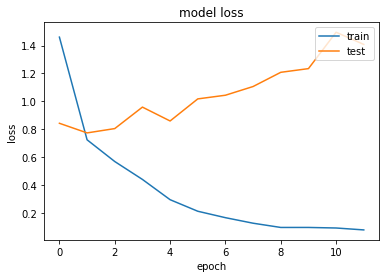

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
trn_prob = model.predict(train_generator)

In [ ]:
trn_prob.shape

(8784, 7)

In [ ]:
tf.keras.models.save_model(model=model, filepath="/content/drive/MyDrive/Kaggle Datasets/Skin Cancer MNIST/model_22_mar_incep")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Kaggle Datasets/Skin Cancer MNIST/model_22_mar_incep/assets


In [ ]:
categories = np.array(df_1["dx"].unique())
categories = np.sort(categories)
print(categories)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [ ]:
details_train = X_train.iloc[:,2:]
train_prob = pd.DataFrame(trn_prob,index=X_train.index,columns=categories)
train_prob.head()

,akiec,bcc,bkl,df,mel,nv,vasc
image_id,,,,,,,
ISIC_0029509.jpg,0.000029,0.000073,0.007392,0.000063,0.000370,0.991953,0.000121
ISIC_0033886.jpg,0.017986,0.024557,0.197373,0.035288,0.054064,0.665895,0.004837
ISIC_0027488.jpg,0.009929,0.029941,0.042102,0.179424,0.011523,0.725568,0.001514
ISIC_0033144.jpg,0.002432,0.005930,0.036000,0.001192,0.119980,0.518313,0.316153
ISIC_0024832.jpg,0.000470,0.002120,0.106063,0.000446,0.035354,0.847414,0.008134


In [ ]:
combined_train = pd.concat([details_train,train_prob],axis=1)
combined_train.head()

,age,sex_male,dx_type_consensus,dx_type_follow_up,dx_type_histo,localization_acral,localization_back,localization_chest,localization_ear,localization_face,localization_foot,localization_genital,localization_hand,localization_lower extremity,localization_neck,localization_scalp,localization_trunk,localization_upper extremity,akiec,bcc,bkl,df,mel,nv,vasc
image_id,,,,,,,,,,,,,,,,,,,,,,,,,
ISIC_0029509.jpg,0.764706,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000029,0.000073,0.007392,0.000063,0.000370,0.991953,0.000121
ISIC_0033886.jpg,0.705882,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.017986,0.024557,0.197373,0.035288,0.054064,0.665895,0.004837
ISIC_0027488.jpg,0.529412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.009929,0.029941,0.042102,0.179424,0.011523,0.725568,0.001514
ISIC_0033144.jpg,1.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002432,0.005930,0.036000,0.001192,0.119980,0.518313,0.316153
ISIC_0024832.jpg,0.470588,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000470,0.002120,0.106063,0.000446,0.035354,0.847414,0.008134


In [ ]:
combined_train.shape

(8784, 25)